# TP - Fuzzy image clustering

## 1. Introduction
Fuzzy c­means (FCM) is a method of clustering which allows one piece of data to belong to two or more
clusters. 

## 2. Preparation
First create a function that reads an image from a file and returns a numpy array.

In [2]:
import cv2

def read_image(img_path):
    img = cv2.imread(img_path)
    #to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img 
read_image("milky-way.jpg").shape

(1024, 1024, 3)

In [3]:
import numpy as np
import traceback, time

## 2. Fuzzy c-means algorithm
Create function that computes the membership value $u_{ij}$ for a given pixel $x_i$ and cluster $c_j$.

In [4]:
def compute_uij(x_i, c_j, cluster_centers, fuzzy_m):
    if type(x_i) == int:
        x_i = np.array([x_i])
    # Calculate the distances once for all clusters
    distances = np.abs(x_i - cluster_centers)
    epsilon = 1e-6
    distances = np.where(distances == 0, epsilon, distances)
    # Calculate the membership value u_ij
    numerator = distances[c_j]  # distance between x_i and c_j 
    denominator = np.sum((numerator / distances) ** (2 / (fuzzy_m - 1)))
    
    return 1.0 / denominator

## 3. Fuzzy c-means class
Create a class that implements the FCM algorithm.
### 3.1. Constructor 
The constructor should take the following parameters:
- k: the number of clusters
- matrix: the image matrix

### 3.2. Initialization
The class should have the following attributes:
- k: the number of clusters
- n: the shape of the image matrix
- matrix: the image matrix
- matrix_U: the membership matrix
- matrix_shaped: the reshaped image matrix into an array of pixels
- centroids: the cluster centers
- fuzzy_m: the fuzziness coefficient
- convergence_rate: the convergence rate

### 3.3. Method init_centroids
This method should initialize the cluster centers randomly.
### 3.4. Method update_centroids
This method should update the cluster centers based on the membership values.
It uses the following formula:
$$
\[
c_j = \frac{\sum_{i=1}^{N} u_{ij}^m \cdot x_i}{\sum_{i=1}^{N} u_{ij}^m}
\]
$$

### 3.5. Method update
This method should update the membership values and the cluster centers.
$$
\[
u_{ij} = \frac{1}{\sum_{k=1}^{C} \left( \frac{\| x_i - c_j \|}{\| x_i - c_k \|} \right)^{\frac{2}{m-1}}}
\]
$$

### 3.6. Method classify_one
This method should classify a single pixel into a cluster.

### 3.7. Method is_converged
This method should check if the algorithm has converged using the convergence rate.

### 3.8. Method run
This method should run the FCM algorithm.
Following the steps:
- Initialize the membership matrix
- Iterate until convergence:
  - Update the membership values
  - Update the cluster centers

In [5]:
class Fcm():
    def __init__(self,k,matrix):
        self.k = k 
        self.n = matrix.shape
        self.matrix = matrix
        self.nb_channels = self.matrix.shape[2] if len(self.matrix.shape) == 3 else 1
        self.matrix_U = np.zeros((self.matrix.shape[0] * self.matrix.shape[1],k)) 
        self.matrix_shaped = self.matrix.reshape(self.matrix_U.shape[0],self.nb_channels)
        self.centroids = []
        self.init_centroids()
        self.fuzzy_m = 1.5
        self.convergence_rate = 0.01
        
        
    def init_centroids(self):
        for i in range(self.k):
            b = np.random.randint(0, 255, size=self.nb_channels)
            if type(b) == int or len(b.shape) == 0:  # If x_i is scalar or 0D, convert to 1D array
                b = np.array([b])
            self.centroids.append(b)
    
    def update_centroids(self):
        for idx, centroid in enumerate(self.centroids):
            # Calculate the nominator using vectorized operations
            denominator = np.sum(self.matrix_U[:, idx] ** self.fuzzy_m)
            nominator = 0
            for i,x in enumerate(self.matrix_shaped):
                nominator += (self.matrix_U[i,idx] ** self.fuzzy_m) * x
            # Update the centroid
            self.centroids[idx] = nominator / denominator
            pass
                
        
    def update(self):
        for i, j in np.ndindex(self.matrix_U.shape):
            self.matrix_U[i, j] = compute_uij(self.matrix_shaped[i],j, self.centroids, self.fuzzy_m)
        self.update_centroids()            
    def classify_one(self,x):
        return np.argmax([compute_uij(x,index,self.centroids,self.fuzzy_m) for index,c in enumerate(self.centroids)])
    
    def is_converged(self):
        #||self.matrix_U - self.matrix_U_1|| < epsilon
        convg = np.linalg.norm(self.matrix_U_1 - self.matrix_U )
        print(f"Convergence: {convg}")
        return  convg < self.convergence_rate
    def generate_heatmaps(self):
        fig = plt.figure(figsize=(self.k * 3, 3))  
        for cluster_index in range(self.k):
            membership_values = fcm.matrix_U[:, cluster_index].reshape(fcm.matrix.shape[0], fcm.matrix.shape[1])
            ax = fig.add_subplot(1, self.k, cluster_index + 1)
            ax.imshow(membership_values, cmap='hot')
            ax.set_title(f'Cluster {cluster_index}', fontsize=12) 
            ax.axis('off')
        
        plt.tight_layout() 
        plt.show()
    def run(self):
        try:
            self.matrix_U_1 = np.ones(self.matrix_U.shape)
            iteration = 0
            print(self.centroids)
            while not self.is_converged() and iteration < 100:
                self.matrix_U_1 = np.copy(self.matrix_U)
                # break 
                start = time.time()
                self.update()
                print(f"Time: {time.time() - start}")
                iteration += 1
                print(f"Iteration {iteration}")
                print(self.centroids)
                # break
        except:
            traceback.print_exc()
        
        
img = read_image("milky-way.jpg")
#remove channels
#to gray
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#resize
# img = cv2.resize(img, (100, 100))
fcm = Fcm(5,img)
fcm.run()

[array([224,   9, 206]), array([ 63,  26, 136]), array([55, 97, 82]), array([143, 120,  15]), array([109, 109, 115])]
Convergence: 2289.7336089597848
Time: 48.46670174598694
Iteration 1
[array([232.64492753, 212.26353722, 207.56457902]), array([43.06615998, 45.42821446, 57.71999331]), array([62.98153772, 64.68994991, 79.589094  ]), array([104.5397543 ,  96.8648382 , 109.55039063]), array([114.42255252, 105.62301842, 115.03637707])]
Convergence: 67.9529007161796
Time: 45.53330206871033
Iteration 2
[array([217.62803662, 195.31617257, 195.852232  ]), array([21.91416822, 25.52416985, 34.71717919]), array([59.67184306, 60.42789525, 74.70286384]), array([102.43930235,  95.37117552, 108.15355677]), array([131.90350838, 119.45794969, 130.57677182])]
Convergence: 272.32128802571503
Time: 44.87778091430664
Iteration 3
[array([216.83761103, 194.4551845 , 195.54704436]), array([17.72867834, 21.50146569, 30.03633199]), array([57.78534252, 58.91865317, 73.28989402]), array([ 98.14271322,  91.8048407

(1024, 1024, 3)


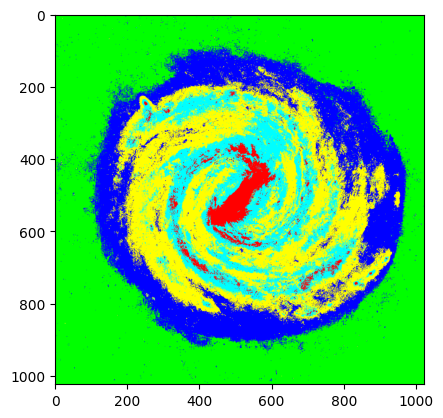

In [6]:
import matplotlib.pyplot as plt

color_class = {
    0 : (255,0,0),
    1 : (0,255,0),
    2: (0,0,255),
    3: (255,255,0),
    4: (0,255,255),
    5: (255,0,255),
}
def segment_image(img,fcm):
    seg_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    class_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    print(img.shape)
    for i,j,k in np.ndindex(img.shape):
        c = fcm.classify_one(img[i,j])
        seg_img[i,j] = color_class[c]
        class_img[i,j] = c
    return seg_img,class_img

img = read_image("milky-way.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.resize(img, (100, 100))
seg_img,class_img = segment_image(img,fcm)

plt.imshow(seg_img)
    

[0 0 0]
(1024, 1024, 3) (1024, 1024)


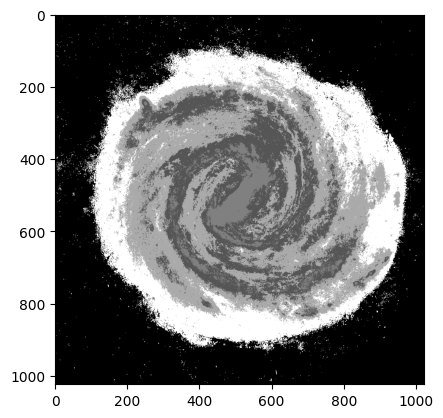

In [52]:
color_class_gray = {
    0 : 0,
    1 : 85,
    2: 170,
    3: 255,
    4: 128,
    5: 42
}

def rgb2gray(rgb_img):
    gray_img = np.zeros(rgb_img.shape[:-1],dtype=np.uint8)
    print(rgb_img.shape,gray_img.shape)
    for i,j in np.ndindex(gray_img.shape):
        gray_img[i,j] = color_class_gray[rgb_img[i,j,0]]
    return gray_img
print(class_img[0,0])
gray_seg_img = rgb2gray(class_img)
plt.imshow(gray_seg_img,cmap='gray')

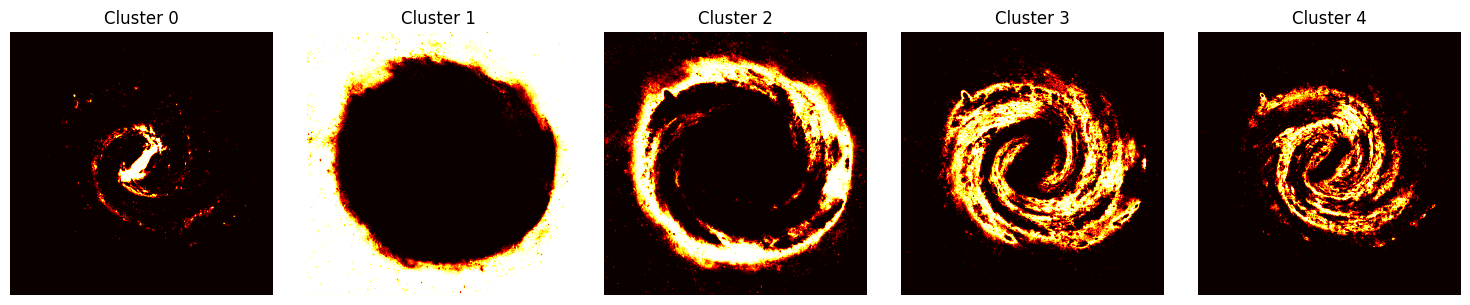

In [7]:
fcm.generate_heatmaps()

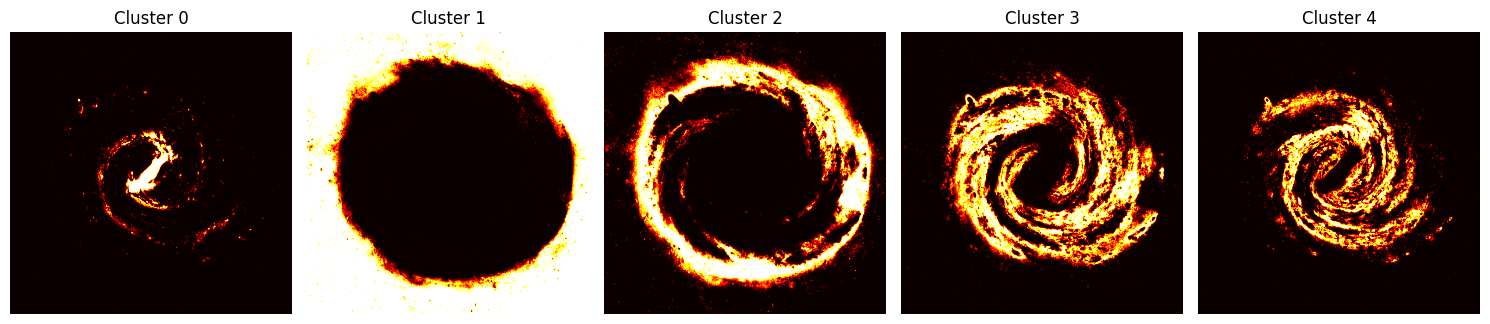

In [17]:
fig = plt.figure(figsize=(fcm.k*3, 20))  
for cluster_index in range(fcm.k):
    membership_values = fcm.matrix_U[:, cluster_index].reshape(fcm.matrix.shape[0], fcm.matrix.shape[1])
    ax = fig.add_subplot(1, fcm.k, cluster_index + 1)
    ax.imshow(membership_values, cmap='hot')
    ax.set_title(f'Cluster {cluster_index}', fontsize=12) 
    ax.axis('off')

plt.tight_layout() 
plt.show()